In [75]:
!git clone https://github.com/jacoponudo/Size_effects.git

Cloning into 'Size_effects'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (16/16), 6.51 KiB | 1.30 MiB/s, done.


In [80]:

root='/kaggle/working/'
import sys
module_path = root+'Size_effects/EXP'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from EXP_package.functions import *
!pip install fastparquet
!pip install gdown

Questa è un analisi per capire su quanti utenti abbiamo un vero e proprio longitudinale di commenti. 
Si definisce longitudinale un dato se abbiamo almento 50 commenti, con un rate di 2 commenti per mese in media.

## Facebook

In [82]:
# Scarica i tre dataset che appartengono a Facebook
import gdown
url='https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB'
output='facebook_news.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=1KGH2s8sPnvXZc7_wVgTCoGTXPr3B7SCe'
output='facebook_brexit.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=17q4X4JHYJBz1jF58XvYfbKqZLy-jtmzM'
output='facebook_vaccines.csv'
gdown.download(url,output,quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB
From (redirected): https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB&confirm=t&uuid=f667fad2-52b1-41ee-bc32-31489e803114
To: /kaggle/working/facebook_news.csv
100%|██████████| 1.84G/1.84G [00:11<00:00, 156MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1KGH2s8sPnvXZc7_wVgTCoGTXPr3B7SCe
From (redirected): https://drive.google.com/uc?id=1KGH2s8sPnvXZc7_wVgTCoGTXPr3B7SCe&confirm=t&uuid=f2c9f17d-16b1-40a8-9a86-f7d857a6f2ff
To: /kaggle/working/facebook_brexit.csv
100%|██████████| 119M/119M [00:00<00:00, 159MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=17q4X4JHYJBz1jF58XvYfbKqZLy-jtmzM
From (redirected): https://drive.google.com/uc?id=17q4X4JHYJBz1jF58XvYfbKqZLy-jtmzM&confirm=t&uuid=c403e31d-6580-4253-813a-a4e0e5bc75e3
To: /kaggle/working/facebook_vaccines.csv
100%|██████████| 599M/599M [00:04<00:00, 146MB/s]  


'facebook_vaccines.csv'

In [83]:
# Leggi i tre dataset con pandas
facebook_news = pd.read_csv('/kaggle/working/facebook_news.csv', dtype={'from_id': str})
facebook_vaccines_all_comments_scored = pd.read_csv('/kaggle/working/facebook_vaccines.csv', dtype={'from_id': str})
facebook_brexit_all_comments_scored = pd.read_csv('/kaggle/working/facebook_brexit.csv', dtype={'from_id': str})

# Etichetta e raggruppa i tre dataset
facebook_vaccines = facebook_vaccines_all_comments_scored.copy()
facebook_vaccines['topic'] = 'Vaccines'

facebook_brexit= facebook_brexit_all_comments_scored.copy()
facebook_brexit['topic'] = 'Brexit'

facebook_news = facebook_news.copy()
facebook_news['topic'] = 'News'

facebook = pd.concat([facebook_vaccines, facebook_brexit, facebook_news])
facebook.reset_index(drop=True, inplace=True)
facebook['user_id']=facebook['from_id']

# Gini index of Activity

Calcoliamo per ogni thread un coefficiente di Gini che misuri la concentrazione dell'attività degli utenti.

100%|██████████| 97052/97052 [00:45<00:00, 2131.05it/s]


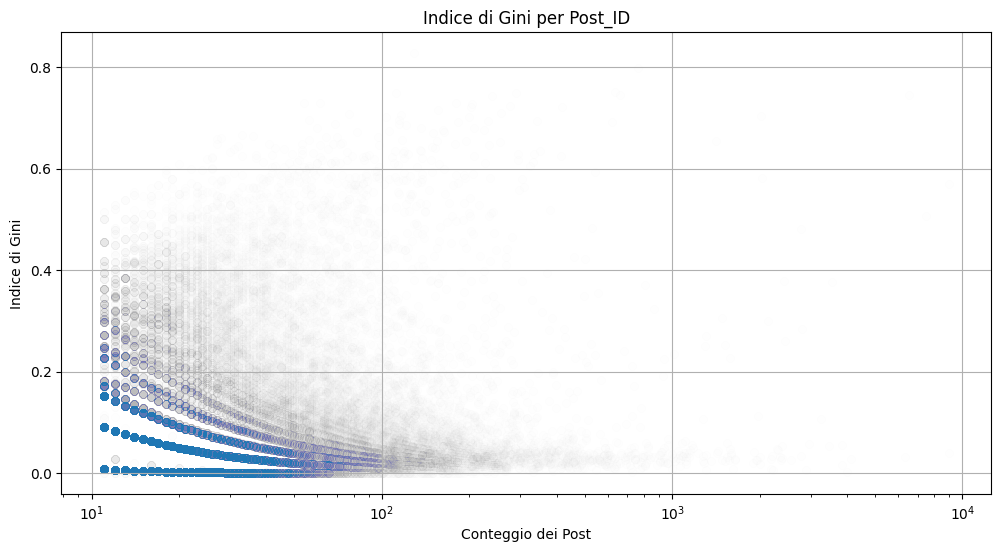

In [134]:
# Conta i commenti per ogni post_id
N_df = facebook['post_id'].value_counts().reset_index()
N_df.columns = ['post_id', 'count']
N_df=N_df[N_df['count']>10]

# Filtra i post con meno di 
fb=facebook[facebook['post_id'].isin(N_df['post_id'])]

# Calcola il coefficiente di gini sulla concentrazione dell'attività degli utenti 
gini_df = calculate_gini_for_posts(fb)

# Unisci i dati sul post_id
merged_df = pd.merge(gini_df, N_df, on='post_id')

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['count'], merged_df['gini_index'], alpha=0.005)
plt.title('Indice di Gini per Post_ID')
plt.xlabel('Conteggio dei Post')
plt.ylabel('Indice di Gini')
plt.xscale('log')  # Log scale for better visualization if the count ranges widely
plt.yscale('linear')  # Adjust scale as needed
plt.grid(True)
plt.show()


Boxplot del coefficiente di gini rispetto al numero di utenti in un thtread

<Figure size 1200x600 with 0 Axes>

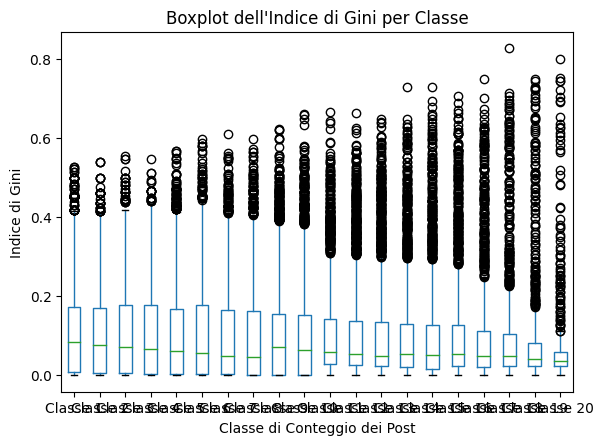

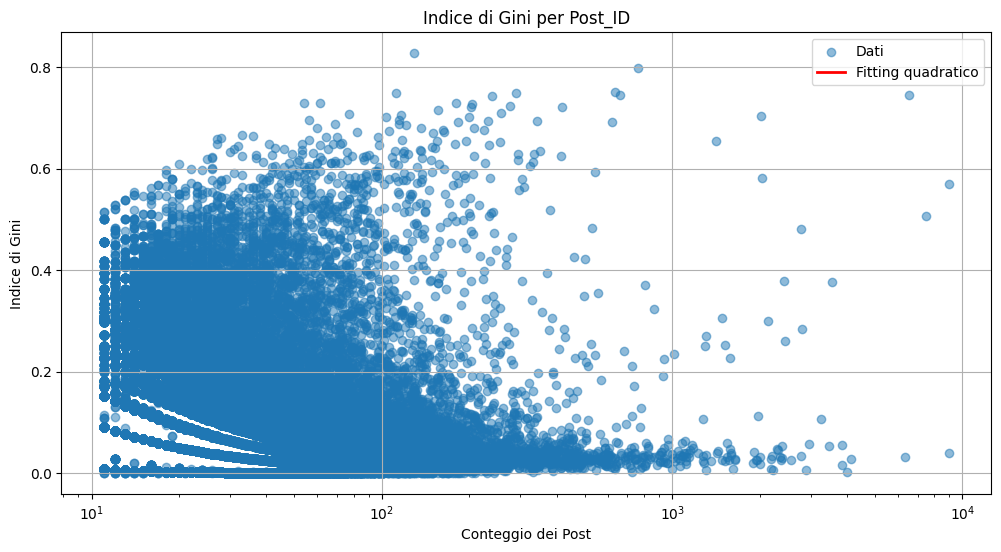

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che merged_df sia già definito e contenga 'count' e 'gini_index'
x = merged_df['count']
y = merged_df['gini_index']

# Creare tre classi omogenee basate sui quantili dei dati
quantiles = np.percentile(x, np.linspace(0, 100, 21))  # 10 classi
labels = [f'Classe {i+1}' for i in range(20)]  # Etichette per le 10 classi
merged_df['classe'] = pd.cut(x, bins=quantiles, labels=labels, include_lowest=True)

# Creare boxplot per le tre classi
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='gini_index', by='classe', grid=False)
plt.title('Boxplot dell\'Indice di Gini per Classe')
plt.suptitle('')  # Rimuovere il titolo generato automaticamente
plt.xlabel('Classe di Conteggio dei Post')
plt.ylabel('Indice di Gini')
plt.show()

